In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from scipy import stats as st

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, extract

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
Base = automap_base()
inspector = inspect(engine)
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Preciptation 

In [10]:
for c in inspector.get_columns("Measurement"):
    print(c["name"],c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
for c in inspector.get_columns("Station"):
    print(c["name"],c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
query = """
        Select 
            *
        from
            station
        limit 100
        """

In [13]:
conn = engine.connect()
df = pd.read_sql(query, con=conn)
conn.close()

In [14]:
df.tail() 

,id,station,name,latitude,longitude,elevation
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Convert to python date time object using pandas

last_date_str = session.query(func.max(Measurement.date)).first()
last_date_pd = pd.to_datetime(last_date_str[0]).to_pydatetime()
one_yr_pd = last_date_pd - dt.timedelta(days=365)
one_yr_str = pd.to_datetime(one_yr_pd).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
#sort data frame by date

monthly_db = session.query(Measurement.date, Measurement.prcp). \
                                    filter(Measurement.date >= one_yr_str).all()

# Save the query results as a Pandas DataFrame
yearly_climate_df = pd.DataFrame( monthly_db )

# Clean the climate data frame by removing NaN values
yearly_climate_df = yearly_climate_df.dropna(how='any')

# Sort the dataframe by date
yearly_climate_df = yearly_climate_df.sort_values(by='date')

# Set Index
yearly_climate_df.set_index(["date"], inplace=True)

# Display to output
yearly_climate_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


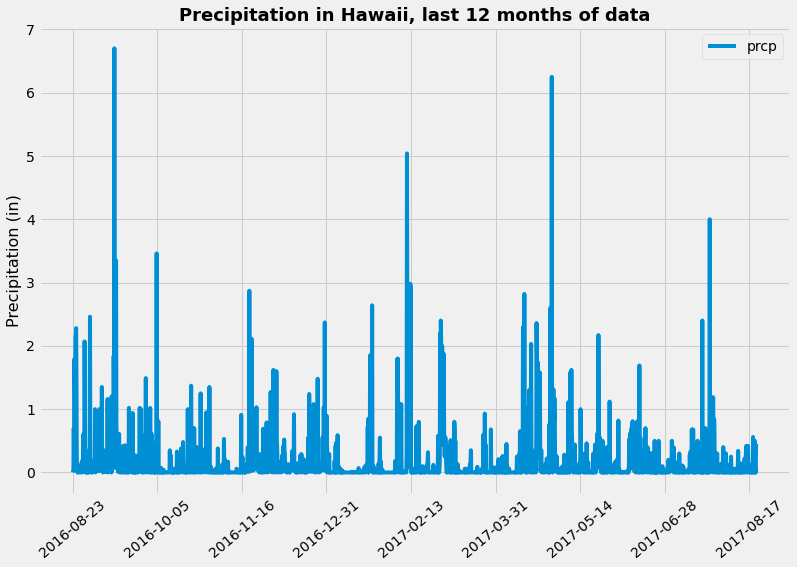

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
yearly_climate_df.plot(y='prcp', use_index=True, figsize = (12,8), rot = 40)

plt.grid(True)
plt.xlabel("")
plt.ylabel("Precipitation (in)", fontsize=16)
plt.title("Precipitation in Hawaii, last 12 months of data", fontweight="bold", fontsize=18)
plt.savefig("Images/Last12MonthsPrecipitationChart.png", bbox_inches='tight')
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
yearly_climate_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Stations

In [18]:
# Design a query to show how many stations are available in this dataset?
station_db = session.query(Station).distinct(Station.station).count()

print(f'Distinct stations avaiable: {station_db}')

Distinct stations avaiable: 9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

query = """
        SELECT
        s.station,
        count(*) as tot_obs
        FROM
            station s
        JOIN measurement m on s.station = m.station
        GROUP BY s.station
        ORDER BY
            count(*) desc
        """

In [20]:
 conn = engine.connect()
df = pd.read_sql(query, con=conn)
conn.close()

df

,station,tot_obs
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [21]:
query = """
        SELECT
            m.date,
            m.prcp,
            m.tobs,
            s.station,
            s.name
        FROM
            measurement m
            join station s on m.station = s.station
        WHERE
            date >= (
                        SELECT
                           date(MAX(date), '-365 day')
                        FROM
                            measurement
                    )
        ORDER BY
            date
        """

In [22]:
conn = engine.connect()
df = pd.read_sql(query, con=conn)
conn.close()

df

,date,prcp,tobs,station,name
0,2016-08-23,0.00,81.0,USC00519397,"WAIKIKI 717.2, HI US"
1,2016-08-23,0.15,76.0,USC00513117,"KANEOHE 838.1, HI US"
2,2016-08-23,0.05,80.0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
3,2016-08-23,NaN,80.0,USC00517948,"PEARL CITY, HI US"
4,2016-08-23,0.02,80.0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US"
...,...,...,...,...,...
2225,2017-08-22,0.50,76.0,USC00516128,"MANOA LYON ARBO 785.2, HI US"
2226,2017-08-23,0.00,81.0,USC00519397,"WAIKIKI 717.2, HI US"
2227,2017-08-23,0.00,82.0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
2228,2017-08-23,0.08,82.0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US"


In [23]:
df.groupby("station").size().sort_values(ascending=False) 

station
USC00519397    361
USC00519281    352
USC00516128    349
USC00513117    343
USC00519523    337
USC00514830    305
USC00517948    183
dtype: int64

In [24]:
# Most active station
active_station = df.groupby("station").size().sort_values(ascending=False).index[0]
#print(active_station)
print(f'The Most active station name is: {active_station}')

active_station_name = session.query(Station.name).filter_by(station = active_station)

for stations in active_station_name:
    print(f'The Most active station is: {stations[0]}')


The Most active station name is: USC00519397
The Most active station is: WAIKIKI 717.2, HI US


In [45]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_temp_db = session.query(Measurement.station, func.min(Measurement.tobs),
                                                          func.max(Measurement.tobs),
                                                          func.avg(Measurement.tobs)).\
                                           filter(Measurement.station == active_station).all()

low_temp  = station_temp_db[0][1]
high_temp = station_temp_db[0][2]
avg_temp = station_temp_db[0][3]

print(f'The Most active station ID for the last twelve months is: {active_station}')
print(f'The Most active station name is: {active_station_name[0][0]}')
print(f'The Most active station lowest temperate recorded is: {low_temp}')
print(f'The Most active station highest temperate recorded is: {high_temp}')
print(f'The Most active station average temperate recorded is: {avg_temp}')


The Most active station ID for the last twelve months is: USC00519397
The Most active station name is: WAIKIKI 717.2, HI US
The Most active station lowest temperate recorded is: 56.0
The Most active station highest temperate recorded is: 87.0
The Most active station average temperate recorded is: 74.55323054331865


In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

monthly_temp = \
            session.query(Measurement.tobs).\
               filter(Measurement.station == active_station).\
               filter(Measurement.station == Station.station).\
               filter(Measurement.date >= one_yr_str).filter(Measurement.date <= last_date_str[0]).all()

temp_df = pd.DataFrame(monthly_temp)

temp_df

,tobs
0,81.0
1,79.0
2,80.0
3,79.0
4,77.0
...,...
356,79.0
357,81.0
358,81.0
359,82.0


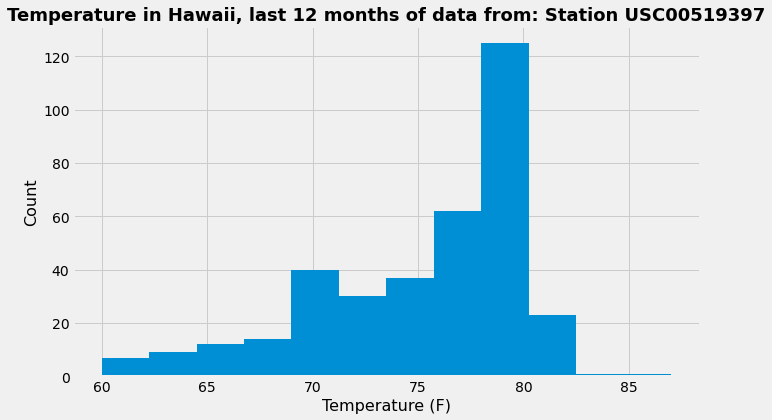

In [27]:
plt.figure(figsize=(10,6))
plt.hist(temp_df.tobs, bins=12)
plt.title(f"Temperature in Hawaii, last 12 months of data from: Station {active_station}", fontweight="bold", fontsize=18)
plt.ylabel("Count", fontsize=16)
plt.xlabel("Temperature (F)", fontsize=16)

plt.show()

In [28]:
temp_df.describe()

,tobs
count,361.000000
mean,75.210526
std,4.963758
min,60.000000
25%,72.000000
50%,77.000000
75%,79.000000
max,87.000000


# Bonus Challenge Assignment

## Temperature Analysis I

In [29]:
#Identify the average temperature in June and December at all stations across all available years in the dataset. 

# select the average tempratures for ALL stations in June
sel = [Measurement.station, func.avg(Measurement.tobs)]

june_query = session.query(*sel).\
    filter(Measurement.date.like('%-06-%')).\
    group_by(Measurement.station)
june_df = pd.DataFrame(june_query, columns=['station_id','avg_temp']).set_index('station_id')

In [30]:
# select the average tempratures for ALL stations in December

december_query = session.query(*sel).\
    filter(Measurement.date.like('%-12-%')).\
    group_by(Measurement.station)
december_df = pd.DataFrame(december_query, columns=['station_id','avg_temp']).set_index('station_id')

In [31]:
temperature_df = june_df.merge(december_df, on='station_id', suffixes=['_june','_december'])
temperature_df

,avg_temp_june,avg_temp_december
station_id,,
USC00511918,74.139394,69.684211
USC00513117,74.050847,71.069444
USC00514830,76.005376,73.224719
USC00516128,71.937220,69.291262
USC00517948,76.655405,71.834862
USC00518838,73.394737,72.421053
USC00519281,73.271186,69.903226
USC00519397,77.559322,71.109524
USC00519523,76.668103,72.433333


In [32]:
# JUNE STATIONS = DECEMBER STATIONS, SO USE PAIRED T-TEST
t, p = st.ttest_rel(temperature_df.avg_temp_june, temperature_df.avg_temp_december)
print(f"T-Value: {t}")
print(f"P-Value: {p}")
print("These results are statistically significant.")

T-Value: 6.95696617044294
P-Value: 0.00011759380231523222
These results are statistically significant.


## Temperature Analysis II

In [33]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-06-28', '2012-07-05'))

[(68.0, 74.49180327868852, 81.0)]


In [34]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#set trip dates and previous dates
trip = '2018-06-28 to 2018-07-05'

start_date = '2018-06-28'
end_date = '2018-07-05'

start_date_pd = pd.to_datetime(start_date).to_pydatetime()
end_date_pd = pd.to_datetime(end_date).to_pydatetime()

#calculate the tmin, tavg, and tmax 
ly_start_pd = start_date_pd - dt.timedelta(days=365)
ly_end_pd = end_date_pd - dt.timedelta(days=365)

ly_start_str = pd.to_datetime(ly_start_pd).strftime('%Y-%m-%d')
ly_end_str = pd.to_datetime(ly_end_pd).strftime('%Y-%m-%d')

trip_db = calc_temps(ly_start_str, ly_end_str)
print(trip_db)


[(74.0, 77.87234042553192, 87.0)]


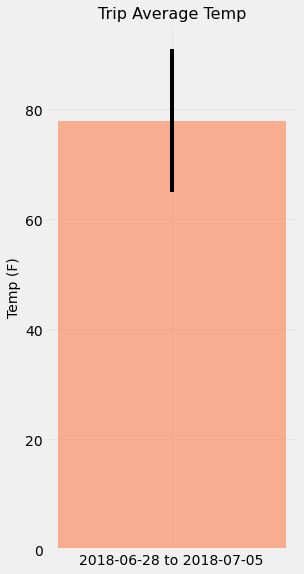

In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


# Load results from previous values into variables
tmin_temp = trip_db[0][0]
tavg_temp = trip_db[0][1]
tmax_temp= trip_db[0][2]

# Plot bar chart
plt.figure(figsize=(4,9))
plt.bar(trip, tavg_temp, yerr=(tmax_temp- tmin_temp), color = 'coral', alpha = .6)

# Title 
plt.title('Trip Average Temp', fontsize = 16)
plt.ylabel('Temp (F)', fontsize = 14)
plt.grid(alpha=.3)

# Save figure file
plt.savefig("Images/TripAvgTemperature.png", bbox_inches='tight')
plt.show()


In [36]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation]

rainfall_data_db = session.query(*sel).\
                 filter(Station.station == Measurement.station).\
                 filter(Measurement.date >= ly_start_str).\
                 filter(Measurement.date <= ly_end_str).\
                 group_by(Measurement.station).\
                 order_by(func.sum(Measurement.prcp).desc()).\
                 all()

rainfall_df = pd.DataFrame(rainfall_data_db,
                           columns= ['Station ID', 'Station Name', 'Total Rainfall', 'Latitude', 'Longitude', 'Elevation'])

#convert query object into data frame
rainfall_df.head()

,Station ID,Station Name,Total Rainfall,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1.26,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",0.47,21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",0.35,21.42340,-157.80150,14.6
3,USC00519397,"WAIKIKI 717.2, HI US",0.20,21.27160,-157.81680,3.0
4,USC00517948,"PEARL CITY, HI US",0.12,21.39340,-157.97510,11.9


In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [38]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
my_trip = '2018-03-01 to 2018-03-12'

my_start_date = '2018-03-01'
my_end_date = '2018-03-12'

date = pd.to_datetime(my_start_date).to_pydatetime()
end_date = pd.to_datetime(my_end_date).to_pydatetime()

# Use the start and end date to create a range of dates
delta = dt.timedelta(days=1)
date_range = []
while date <= end_date:
    date_range.append(date)
    date = date + delta

# print(dt.date(date_range))
trip_daily_normals = []

# Strip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
for dates in date_range:
    date_format= dates.strftime("%m-%d")
    daily_normal = daily_normals(date_format)
    trip_daily_normals.append(daily_normal)
    
trip_daily_normals


[[(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)],
 [(60.0, 67.89090909090909, 76.0)],
 [(60.0, 69.20338983050847, 76.0)],
 [(60.0, 69.17241379310344, 78.0)],
 [(59.0, 68.72413793103448, 78.0)],
 [(57.0, 68.56140350877193, 75.0)],
 [(57.0, 69.12280701754386, 75.0)],
 [(60.0, 69.89285714285714, 82.0)],
 [(62.0, 69.88888888888889, 80.0)]]

In [39]:
date = []
for dates in date_range:
    date_format= dates.strftime("%Y-%m-%d")
    date.append(date_format)
date

['2018-03-01',
 '2018-03-02',
 '2018-03-03',
 '2018-03-04',
 '2018-03-05',
 '2018-03-06',
 '2018-03-07',
 '2018-03-08',
 '2018-03-09',
 '2018-03-10',
 '2018-03-11',
 '2018-03-12']

In [40]:
# Loop through the list of daily normals
min_temp = []
avg_temp = []
max_temp = []

for normals in trip_daily_normals:
    min= normals[0][0]
    avg = normals [0][1]
    max = normals[0][2]
    min_temp.append(min)
    avg_temp.append(avg)
    max_temp.append(max)

In [41]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
#load into a data frame
trip_df = pd.DataFrame({"date": date, "tmin" : min_temp, "tavg": avg_temp, 
                                    "tmax": max_temp
                                    })
    

#set index
trip_df.set_index('date', inplace = True)

#display
trip_df.head()

,tmin,tavg,tmax
date,,,
2018-03-01,64.0,70.032787,76.0
2018-03-02,61.0,70.366667,78.0
2018-03-03,60.0,70.068966,78.0
2018-03-04,57.0,69.272727,77.0
2018-03-05,60.0,67.890909,76.0


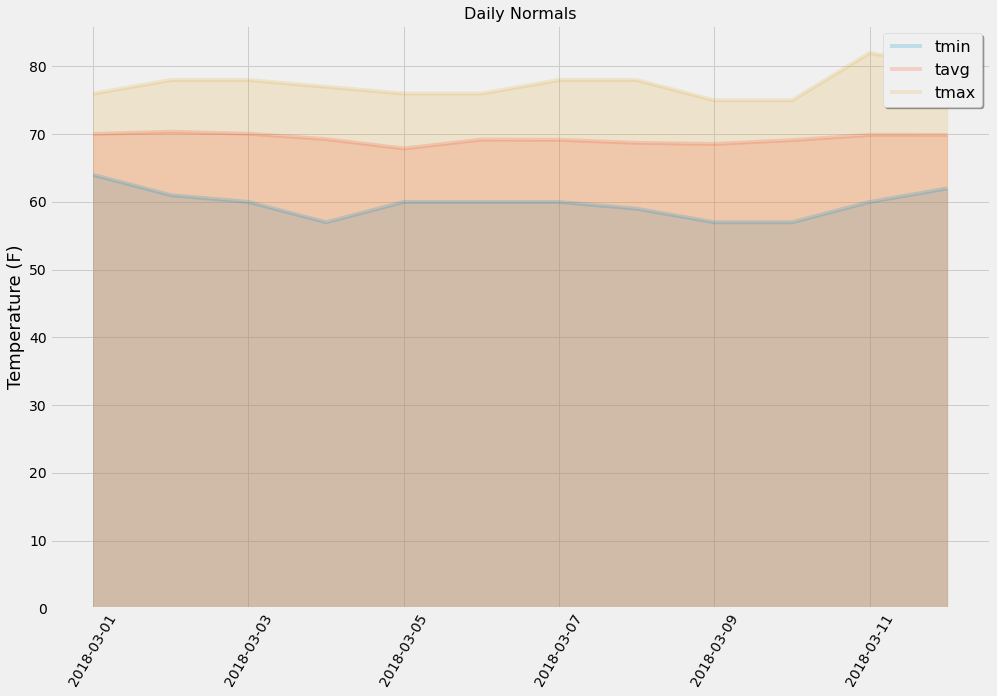

In [42]:
# Plot the daily normals as an area plot with `stacked=False`

trip_df.plot.area(stacked=False, alpha=.2, figsize=(15,10), rot = 60)

column_name = ["tmin","tavg","tmax"]
legend = plt.legend(column_name, loc="upper right", shadow=True, fontsize=16,  fancybox=True)

plt.grid(True)
plt.xlabel("", fontsize = 18)
plt.ylabel("Temperature (F)", fontsize = 18)
plt.title("Daily Normals", fontsize = 16)


# Save figure file
plt.savefig("Images/DailyNormalsAreaPlot.png", bbox_inches='tight')
plt.show()